In [16]:
import sys

sys.path.append("../../")
import subprocess
import typing
from multiprocessing import Pool

import numpy as np
import pandas as pd
import ROOT
import seaborn as sns

from utils.RootPDConverter import RootPDConverter

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
folder = "/lustre/r3b/ywang/test/first_hit"
channels = ["tamex", "tacquila", "mock"]
paddles = ["neuland", "mock"]
event_number = 100000


def get_filename(paddle, channel):
    return f"digi_{paddle}_paddle_{channel}_channel.root"


def get_logfilename(paddle, channel):
    return f"digi_{paddle}_paddle_{channel}_channel.log"


def neuland_ana(paddle, channel):
    filename = get_filename(paddle, channel)
    logfilename = get_logfilename(paddle, channel)
    with open(f"{folder}/{logfilename}", "w") as f:
        subprocess.call(
            f"""neulandAna --digiFile {folder}/{filename} --paddle '{paddle}' \
            --channel '{channel}' --simuFile {folder}/simu.root \
            --paraFile {folder}/para.root""",
            shell=True,
            stdout=f,
            stderr=f,
        )
    # !neulandAna --digiFile "{folder}/{filename}" --paddle {paddle} --channel {channel}

In [70]:
# !neulandSim --eventNum {event_number} --eventPrint {event_number//10} --simuFile {folder}/simu.root --paraFile {folder}/para.root
with Pool(99) as p:
    p.starmap(
        neuland_ana, [(paddle, channel) for channel in channels for paddle in paddles]
    )

In [19]:
# folder = "/lustre/land/ilihtar/neuland/sim_August24"
# digi_file_name = "digi1n_phasespace_25MeV_thresh0.root"
# simu_file_name = "sim1n_phasespace_25MeV.root"
simu_file_name = "simu.root"
digi_filenames = [
    (paddle, channel, get_filename(paddle, channel))
    for paddle in paddles
    for channel in channels
]
point_branches = {
    "NeulandPoints.fTime": "float",
    "NeulandPoints.fDetectorID": "int",
    "NeulandPoints.fELoss": "float64",
}

hit_branches = {
    "NeulandHits.fT": "float",
    "NeulandHits.fPaddle": "int",
    "NeulandHits.fE": "float64",
}

point_all_branches = {
    "NeulandPoints.fTime": "float",
    "NeulandPoints.fDetectorID": "int32",
    "NeulandPoints.fELoss": "float64",
    "NeulandPoints.fX": "float64",
    "NeulandPoints.fY": "float64",
}

simu_point_branches_rename = {
    "NeulandPoints.fTime": "times",
    "NeulandPoints.fELoss": "energies",
    "NeulandPoints.fDetectorID": "module_num",
}
hit_point_branches_rename = {
    "NeulandHits.fT": "times",
    "NeulandHits.fPaddle": "module_num",
    "NeulandHits.fE": "energies",
}

In [34]:
def create_first_hit_data_frame(
    data_frame: pd.DataFrame,
    paddle_label: str = "",
    channel_label: str = "",
    simu_dataframe=pd.DataFrame(),
):
    data_frame_first_hit = data_frame.loc[
        data_frame.groupby("event_id")["times"].idxmin()
    ]
    data_frame_first_hit["plane_id"] = (data_frame_first_hit["module_num"] - 1) // 50
    data_frame_first_hit["energies"] = data_frame_first_hit["energies"] * 1000
    if not simu_dataframe.empty:
        new_simu = simu_dataframe.copy()
        new_simu["level"] = "points"
        data_frame_first_hit["level"] = "hits"
        data_frame_first_hit = pd.concat([data_frame_first_hit, new_simu])
    if paddle_label != "":
        data_frame_first_hit["paddle"] = paddle_label
    if channel_label != "":
        data_frame_first_hit["channel"] = channel_label
    return data_frame_first_hit

In [35]:
converter = RootPDConverter(point_branches)

simu = converter.convert_to_dataframe(
    f"{folder}/{simu_file_name}", simu_point_branches_rename
)
simu = create_first_hit_data_frame(simu)

converter.branches_types = hit_branches

dataframes = [
    create_first_hit_data_frame(
        converter.convert_to_dataframe(
            f"{folder}/{filename}", hit_point_branches_rename
        ),
        paddle,
        channel,
        simu,
    )
    for paddle, channel, filename in digi_filenames
]

In [37]:
dataframes[1]

,times,module_num,energies,event_id,plane_id,level,paddle,channel
0,62.364963,90,12798.308688,1,1,hits,neuland,tacquila
25,63.950927,639,84567.473002,2,12,hits,neuland,tacquila
37,66.652736,724,4665.397269,4,14,hits,neuland,tacquila
43,61.960750,73,23679.358177,5,1,hits,neuland,tacquila
71,64.912432,235,8436.211975,6,4,hits,neuland,tacquila
...,...,...,...,...,...,...,...,...
5013968,61.907249,420,0.078734,99995,8,points,neuland,tacquila
5013969,65.985344,839,0.060141,99996,16,points,neuland,tacquila
5013971,62.364697,183,1.260392,99997,3,points,neuland,tacquila
5014075,61.014797,107,0.137448,99998,2,points,neuland,tacquila


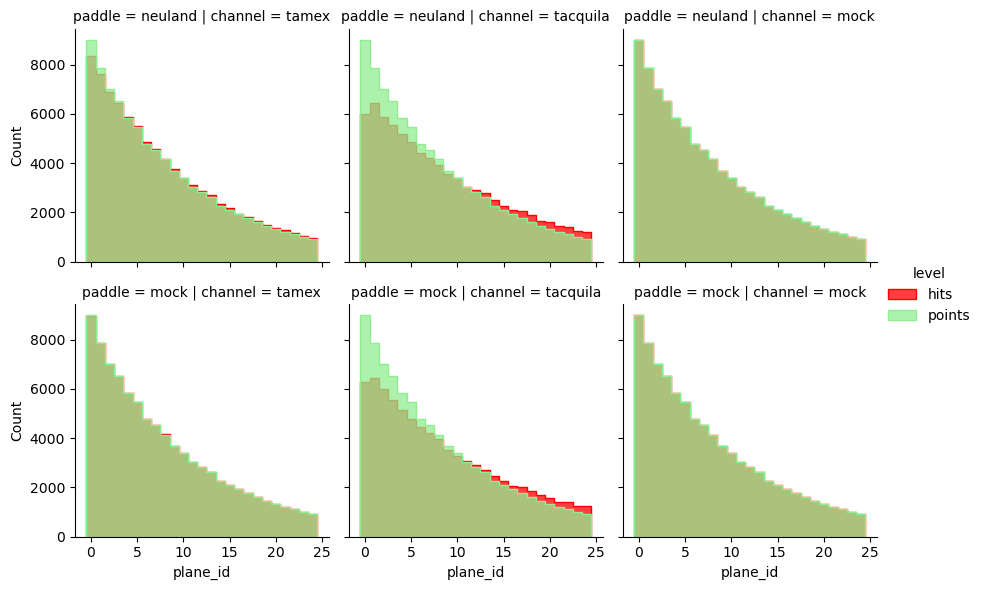

In [39]:
plane_id_compare = pd.concat(dataframes)

graphs = sns.FacetGrid(
    plane_id_compare,
    col="channel",
    row="paddle",
    hue="level",
    palette=["red", "lightgreen"],
)
graphs.map_dataframe(
    sns.histplot,
    x="plane_id",
    binwidth=1,
    binrange=[-0.5, 24.5],
    element="step",
    fill=True,
)
graphs.add_legend()

In [105]:
converter = RootPDConverter(point_all_branches)
simu_all_data = converter.convert_to_dataframe(simu_file_name, folder);

In [106]:
# simu_all_data = simu_all_data.astype({"NeulandPoints.fDetectorID": 'int32'})
simu_all_data["plane_id"] = (simu_all_data["NeulandPoints.fDetectorID"] - 1) // 50
simu_all_data["energy"] = simu_all_data["NeulandPoints.fELoss"] * 1000
simu_all_data

,NeulandPoints.fTime,NeulandPoints.fDetectorID,NeulandPoints.fELoss,NeulandPoints.fX,NeulandPoints.fY,event_id,plane_id,energy
0,62.308582,90,0.000501,71.475754,36.497025,1,1,0.501297
1,62.345554,90,0.000101,72.503677,36.622940,1,1,0.100598
2,62.308582,90,0.000261,71.475754,36.497025,1,1,0.260951
3,62.514935,134,0.000521,71.643814,40.099998,1,2,0.520754
4,62.891151,191,0.000074,75.099998,32.319656,1,3,0.074375
...,...,...,...,...,...,...,...,...
5014124,63.568794,827,0.029218,-84.419205,6.593771,99999,16,29.218309
5014125,63.932762,828,0.009012,-87.426483,10.100000,99999,16,9.011734
5014126,64.061020,858,0.018702,-88.439491,11.245692,99999,17,18.702170
5014127,64.286636,857,0.044240,-90.099998,13.187169,99999,17,44.240013


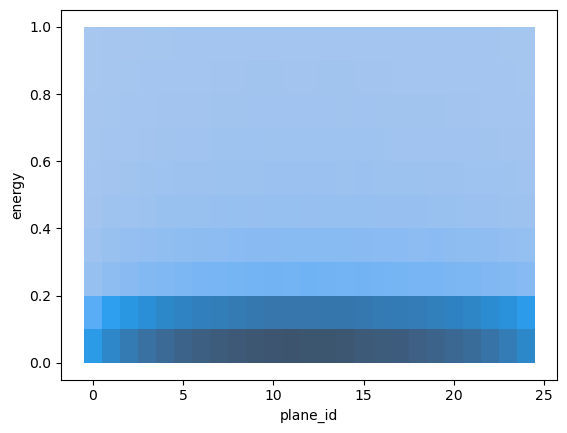

In [68]:
g = sns.histplot(
    data=simu_all_data,
    x="plane_id",
    y="energy",
    binwidth=(1, 0.1),
    binrange=[[-0.5, 24.5], [0.0, 1.0]],
)

<Axes: xlabel='plane_id', ylabel='Count'>

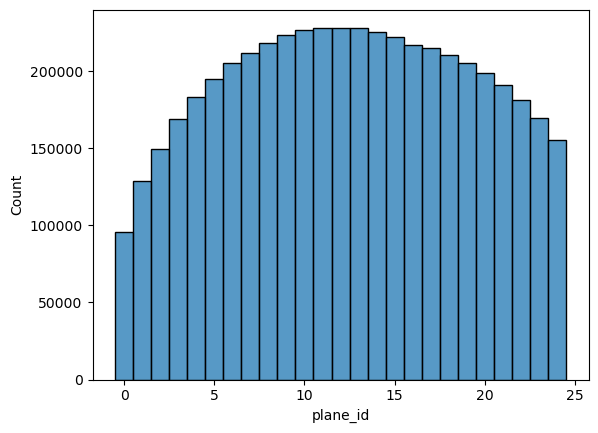

In [66]:
sns.histplot(data=simu_all_data, x="plane_id", binwidth=1, binrange=[-0.5, 24.5])

<Axes: xlabel='plane_id', ylabel='NeulandPoints.fX'>

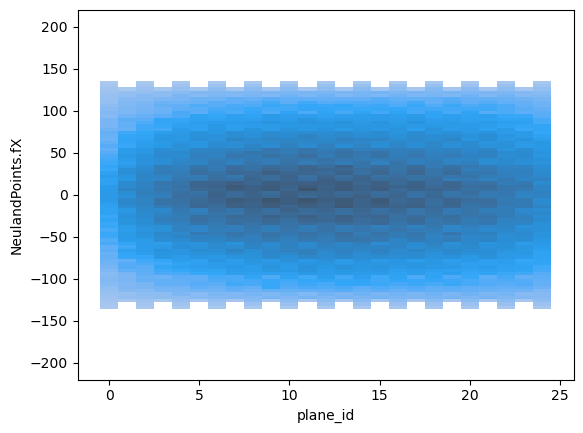

In [56]:
sns.histplot(
    data=simu_all_data,
    x="plane_id",
    y="NeulandPoints.fX",
    binwidth=(1, 4),
    binrange=[[-0.5, 24.5], [-200, 200]],
)

<Axes: xlabel='plane_id', ylabel='NeulandPoints.fY'>

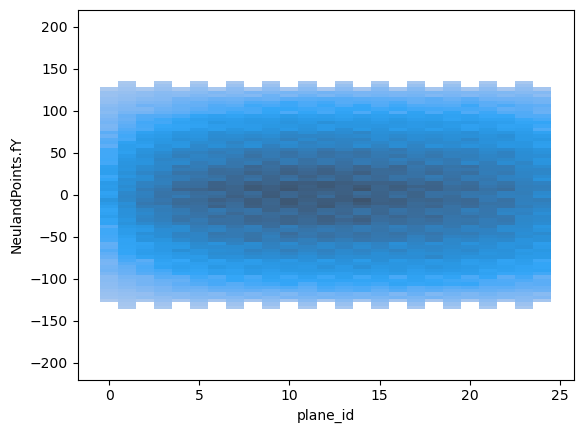

In [57]:
sns.histplot(
    data=simu_all_data,
    x="plane_id",
    y="NeulandPoints.fY",
    binwidth=(1, 4),
    binrange=[[-0.5, 24.5], [-200, 200]],
)